In [ ]:
import math
import random
import os
import numpy as np
import pandas as pd
from osgeo import gdal, osr
from tqdm.notebook import tqdm

import requests
import matplotlib.pyplot as plt
from io import BytesIO
import logging
import time

In [ ]:
BASE_DIR1 = '/media/sandesh/DATA/ENGINEERING/5th SEM/Minor Project/Mali'
BASE_DIR = '/home/sandesh/Documents/Minor Project/predicting-poverty-replication'
PROCESSED_DIR = os.path.join(BASE_DIR1, 'processed')
# can try using the google downloader, in which case change this to be your google api token
ACCESS_TOKEN_DIR = os.path.join(BASE_DIR1, 'planet_api_key.txt')

RANDOM_SEED = 7 # for reproducibility

# each cluster must have AT LEAST this many images after doing nightlights processing
MIN_IMAGES_PER_CLUSTER = 10

In [ ]:
import sys
sys.path.append(BASE_DIR)
from utils import create_space

In [ ]:
df_mli = pd.read_csv(os.path.join(BASE_DIR1, 'processed/clusters.csv'))

In [ ]:
df_mli.head()

,country,cluster_lat,cluster_lon,cons_pc,nightlights
0,mli,10.315847,-6.105348,2.159553,0.0
1,mli,10.404650,-5.891725,0.778903,0.0
2,mli,10.466931,-7.938471,2.292946,0.0
3,mli,10.513494,-5.978286,3.250503,0.0
4,mli,10.535882,-8.152684,3.772908,0.0


In [ ]:
def generate_download_locations(df, ipc=50):
    '''
    Takes a dataframe with columns cluster_lat, cluster_lon
    Generates a 10km x 10km bounding box around the cluster and samples 
    ipc images per cluster. First samples in a grid fashion, then any 
    remaining points are randomly (uniformly) chosen
    '''
    np.random.seed(RANDOM_SEED) # for reproducability
    df_download = {'image_name': [], 'image_lat': [], 'image_lon': [], 'cluster_lat': [], 
                   'cluster_lon': [], 'cons_pc': [], 'nightlights': [] }
    
    # side length of square for uniform distribution
    edge_num = math.floor(math.sqrt(ipc))
    for _, r in df.iterrows():
        min_lat, min_lon, max_lat, max_lon = create_space(r.cluster_lat, r.cluster_lon)
        lats = np.linspace(min_lat, max_lat, edge_num).tolist()
        lons = np.linspace(min_lon, max_lon, edge_num).tolist()

        # performs cartesian product
        uniform_points = np.transpose([np.tile(lats, len(lons)), np.repeat(lons, len(lats))])
        
        lats = uniform_points[:,0].tolist()
        lons = uniform_points[:,1].tolist()
        
        # fills the remainder with random points
        for _ in range(ipc - edge_num * edge_num):
            lat = random.uniform(min_lat, max_lat)
            lon = random.uniform(min_lon, max_lon)
            lats.append(lat)
            lons.append(lon)
        
        # add to dict
        for lat, lon in zip(lats, lons):
            # image name is going to be image_lat_image_lon_cluster_lat_cluster_lon.png
            image_name = str(lat) + '_' + str(lon) + '_' + str(r.cluster_lat) + '_' + str(r.cluster_lon) + '.png'
            df_download['image_name'].append(image_name)
            df_download['image_lat'].append(lat)
            df_download['image_lon'].append(lon)
            df_download['cluster_lat'].append(r.cluster_lat)
            df_download['cluster_lon'].append(r.cluster_lon)
            df_download['cons_pc'].append(r.cons_pc)
            df_download['nightlights'].append(r.nightlights)
        
    return pd.DataFrame.from_dict(df_download)

In [ ]:
df_mli_download = generate_download_locations(df_mli)

In [ ]:
df_mli_download.shape

(41200, 7)

In [ ]:
df_mli_download.head()

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,cons_pc,nightlights
0,10.270931292294023_-6.150263351995977_10.31584...,10.270931,-6.150263,10.315847,-6.105348,2.159553,0.0
1,10.285903213696015_-6.150263351995977_10.31584...,10.285903,-6.150263,10.315847,-6.105348,2.159553,0.0
2,10.300875135098007_-6.150263351995977_10.31584...,10.300875,-6.150263,10.315847,-6.105348,2.159553,0.0
3,10.3158470565_-6.150263351995977_10.3158470565...,10.315847,-6.150263,10.315847,-6.105348,2.159553,0.0
4,10.330818977901991_-6.150263351995977_10.31584...,10.330819,-6.150263,10.315847,-6.105348,2.159553,0.0


In [ ]:
df_mli_download['country'] = 'mli'

In [ ]:
df_mli_download['nightlights'].max()

13.745539665222168

In [ ]:
print((df_potential_download['nightlights'] == 0).mean())
print((df_potential_download['nightlights'] <= 2).mean())

0.8021844660194175
0.9866504854368932


In [ ]:
def drop_0s(df, fr=0.1):
 
    np.random.seed(RANDOM_SEED)
    c_z = (df['nightlights']==0).sum()
    n = len(df)
    assert c_z / n > fr, print(f'Dataframe already has under {fr} zeros')
    
    d = (c_z - n * fr) / (1 - fr)
    d = int(d)
    print(f'dropping: {d}')
    
    zero_df = df[df['nightlights']==0]
    zero_clusters = zero_df.groupby(['cluster_lat', 'cluster_lon'])
    per_cluster_drop = int(d / len(zero_clusters))
    print(f'Need to drop {per_cluster_drop} per cluster with 0 nightlights')
    
    drop_inds = []
    for (cluster_lat, cluster_lon), group in zero_clusters:
        z_inds = group.index
        clust_drop = np.random.choice(z_inds, per_cluster_drop, replace=False)
        assert len(group) - len(clust_drop) >= MIN_IMAGES_PER_CLUSTER, print(f'dropping too many in {cluster_lat}, {cluster_lon}')
        drop_inds += clust_drop.tolist()
    
    return df.drop(drop_inds).reset_index(drop=True)

def drop_in_range(df, lower=0, upper=2, fr=0.25):

    np.random.seed(RANDOM_SEED)
    boolean_idx = ((lower <= df['nightlights']) & (df['nightlights'] <= upper))
    c_under = boolean_idx.sum()
    n = len(df)
    assert c_under / n > fr, print(f'Dataframe already has under {fr} rows in the given range')
    
    d = (c_under - n * fr) / (1 - fr)
    d = int(d)
    print(f'dropping: {d}')
    
    select_df = df[boolean_idx]
    select_clusters = select_df.groupby(['cluster_lat', 'cluster_lon'])
    per_cluster_drop = int(d / len(select_clusters))
    print(f'Need to drop {per_cluster_drop} per cluster in the given range')
    
    drop_inds = []
    for (cluster_lat, cluster_lon), group in select_clusters:
        z_inds = group.index
        clust_drop = np.random.choice(z_inds, per_cluster_drop, replace=False)
        assert len(group) - len(clust_drop) >= MIN_IMAGES_PER_CLUSTER, print(f'dropping too many in {cluster_lat}, {cluster_lon}')
        drop_inds += clust_drop.tolist()
        
    return df.drop(drop_inds).reset_index(drop=True)


In [ ]:
((0.001 <= df_mli_download['nightlights']) & (df_mli_download['nightlights'] <= 3)).mean()

0.17475728155339806

In [ ]:
(df_mli_download['nightlights'] == 0).mean()

0.8021844660194175

In [ ]:
df_mli_download = drop_0s(df_mli_download, fr=0.6)

dropping: 20825
Need to drop 31 per cluster with 0 nightlights


In [ ]:
(df_mli_download['nightlights'] == 0).mean()

0.6064513013665556

In [ ]:
df_mli_download = drop_0s(df_mli_download, fr=0.43)

dropping: 6410
Need to drop 9 per cluster with 0 nightlights


In [ ]:
(df_mli_download['nightlights'] == 0).mean()

0.4478319783197832

In [ ]:
from sklearn.mixture import GaussianMixture as GMM
X = df_mli_download['nightlights'].values.reshape(-1,1)
gmm = GMM(n_components=3).fit(X)
labels = gmm.predict(df_mli_download['nightlights'].values.reshape(-1,1))

In [ ]:
(labels==0).mean(), (labels==1).mean(), (labels==2).mean()

(0.657859078590786, 0.06775067750677506, 0.27439024390243905)

In [ ]:
df_mli_download.count()

image_name     14760
image_lat      14760
image_lon      14760
cluster_lat    14760
cluster_lon    14760
cons_pc        14760
nightlights    14760
country        14760
dtype: int64

In [ ]:
label0_max = df_mli_download['nightlights'][labels==0].max()
label1_max = df_mli_download['nightlights'][labels==1].max()
label2_max = df_mli_download['nightlights'][labels==2].max()

label0_max, label1_max, label2_max

(0.008317447267472744, 13.745539665222168, 0.785564124584198)

In [ ]:
label0_max = 0.05
label1_max = 5
label2_max = 70

In [ ]:
def query_df(df, lower, upper):
    return df[((lower <= df['nightlights']) & (df['nightlights'] < upper))]

print(len(query_df(df_mli_download, 0, label0_max)) / len(df_mli_download))
print(len(query_df(df_mli_download, label0_max, label1_max)) / len(df_mli_download))
print(len(query_df(df_mli_download, label1_max, label2_max)) / len(df_mli_download))

0.752710027100271
0.22018970189701897
0.02710027100271003


In [ ]:
def create_nightlights_bin(df, cutoffs):
    assert len(cutoffs) >= 2, print('need at least 2 bins')
    cutoffs = sorted(cutoffs, reverse=True)
    labels = list(range(len(cutoffs)))[::-1]
    df['nightlights_bin'] = len(cutoffs)
    for cutoff, label in zip(cutoffs, labels):
        df['nightlights_bin'].loc[df['nightlights'] <= cutoff] = label

df_download = df_mli_download.copy()
create_nightlights_bin(df_download, cutoffs=[label0_max, label1_max, label2_max])

/home/sandesh/.local/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/sandesh/.local/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/sandesh/.local/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

In [ ]:

(df_download['nightlights_bin']==0).mean(), (df_download['nightlights_bin']==1).mean(), (df_download['nightlights_bin']==2).mean()


(0.752710027100271, 0.22018970189701897, 0.02710027100271003)

In [ ]:
df_download.shape

(14760, 9)

In [ ]:
df_download.to_csv(os.path.join(BASE_DIR1, 'processed/image_download_locs.csv'), index=False)

In [ ]:
df_download = pd.read_csv(os.path.join(BASE_DIR1, 'processed/image_download_locs.csv'))

In [ ]:
from utils import PlanetDownloader
import requests

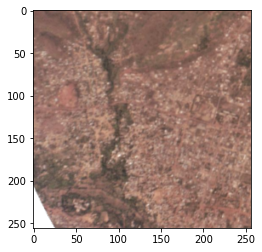

In [ ]:
lat = 12.75042198
lon = -8.080008384
min_year = 2014
min_month = 1
max_year = 2015
max_month = 12

access = open(ACCESS_TOKEN_DIR, 'r').readlines()[0].strip()
pd = PlanetDownloader('85a9f8012ec54eb1be5686114246dcf8')
plt.imshow(pd.download_image(lat, lon, min_year, min_month, max_year, max_month))

In [ ]:
def download_images(df):
    """
    Download images using a pandas DataFrame that has "image_lat", "image_lon", "image_name", "country" as columns
    
    Saves images to the corresponding country's images folder

    To use the Google Downloader, switch PlanetDownloader to GoogleDownloader and make imd.download_image only
    provide lat and lon as arguments. Use zoom = 16.
    """
    import requests
    imd = PlanetDownloader('d2f9677f4bea4e69bd588675d4075b0a')
    num_retries = 20
    wait_time = 0.1 # seconds

    # drops what is already downloaded 
    already_downloaded = os.listdir(os.path.join(BASE_DIR1, 'mali_2015', 'images'))                         
    already_downloaded =  list(set(already_downloaded).intersection(set(df['image_name'])))
    print('Already downloaded ' + str(len(already_downloaded)))
    df = df.set_index('image_name').drop(already_downloaded).reset_index()
    print('Need to download ' + str(len(df)))
    # use three years of images to find one that matches search critera
    min_year = 2014
    min_month = 1
    max_year = 2016
    max_month = 12
    for _, r in tqdm(df.iterrows(), total=df.shape[0]):
        lat = r.image_lat
        lon = r.image_lon
        name = r.image_name
        country_dir = None
        if r.country == 'mli':
            country_dir = 'mali_2015'
        else:
            print(f"unrecognized country: {r.country}")
            raise ValueError()         
        image_save_path = os.path.join(BASE_DIR1, country_dir, 'images', r.image_name)
        try:   
            im = imd.download_image(lat, lon, min_year, min_month, max_year, max_month)    
            if (type(im) == str and im == 'RETRY') or im is None:
                resolved = False
                for _ in range(num_retries):
                    time.sleep(wait_time)        
                    im = imd.download_image(lat, lon, min_year, min_month, max_year, max_month)
                    if (type(im) == str and im == 'RETRY') or im is None:
                        
                        continue
                    else:
                        
                        plt.imsave(image_save_path, im)
                        resolved = True
                        break
                if not resolved:
                    print(f'Could not download {lat}, {lon} despite several retries and waiting')
                    continue
                else:
                    pass
            else:
                # no issues, save according to naming convention
                plt.imsave(image_save_path, im)

        except Exception as e:
            print("Exception: ",e)
            logging.error(f" this Error-could not download {lat}, {lon}", exc_info=True)
            continue

In [ ]:
download_images(df_download)

Already downloaded 0
Need to download 14760


ERROR:root: this Error-could not download 13.522855429003982, -3.706579406556016
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/urllib3/response.py", line 685, in _update_chunk_length
    self.chunk_left = int(line, 16)
ValueError: invalid literal for int() with base 16: b''

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/urllib3/response.py", line 425, in _error_catcher
    yield
  File "/usr/lib/python3/dist-packages/urllib3/response.py", line 752, in read_chunked
    self._update_chunk_length()
  File "/usr/lib/python3/dist-packages/urllib3/response.py", line 689, in _update_chunk_length
    raise httplib.IncompleteRead(line)
http.client.IncompleteRead: IncompleteRead(0 bytes read)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/requests/models.py", line 750, in gener

Exception:  ('Connection broken: IncompleteRead(0 bytes read)', IncompleteRead(0 bytes read))


ERROR:root: this Error-could not download 14.953305259, -3.4026991927959758
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/urllib3/response.py", line 685, in _update_chunk_length
    self.chunk_left = int(line, 16)
ValueError: invalid literal for int() with base 16: b''

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/urllib3/response.py", line 425, in _error_catcher
    yield
  File "/usr/lib/python3/dist-packages/urllib3/response.py", line 752, in read_chunked
    self._update_chunk_length()
  File "/usr/lib/python3/dist-packages/urllib3/response.py", line 689, in _update_chunk_length
    raise httplib.IncompleteRead(line)
http.client.IncompleteRead: IncompleteRead(0 bytes read)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/requests/models.py", line 750, in generate
 

Exception:  ('Connection broken: IncompleteRead(0 bytes read)', IncompleteRead(0 bytes read))
Could not download 15.084054711401992, -10.530120940096015 despite several retries and waiting
Could not download 15.0857674692, -10.533497054294024 despite several retries and waiting
Could not download 15.081630861396015, -10.5415413555 despite several retries and waiting
Could not download 15.081630861396015, -10.526569434098008 despite several retries and waiting
Could not download 15.085602829996017, -10.538630073794025 despite several retries and waiting
Could not download 15.075156527594025, -10.543423710794023 despite several retries and waiting
Could not download 15.090128448996015, -10.543423710794023 despite several retries and waiting

